In [1]:
import pandas as pd
import numpy as np 
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import os 
import cv2
#import tensorflow_addons as tfa

In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [4]:
'from google.colab import drive
drive.mount('/content/drive')

SyntaxError: ignored

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/traindata.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/traindata/cherry/cherry_1991.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._cherry_1991.jpg  
  inflating: /content/traindata/cherry/cherry_0457.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._cherry_0457.jpg  
  inflating: /content/traindata/cherry/cherry_1749.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._cherry_1749.jpg  
  inflating: /content/traindata/cherry/cherry_0331.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._cherry_0331.jpg  
  inflating: /content/traindata/cherry/190.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._190.jpg  
  inflating: /content/traindata/cherry/184.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._184.jpg  
  inflating: /content/traindata/cherry/cherry_2254.jpg  
  inflating: /content/__MACOSX/traindata/cherry/._cherry_2254.jpg  
  inflating: /content/traindata/tomato/63.jpg  
  inflating: /content/__MACOSX/traindata/tomato/._63.jpg  

#Loading data 

In [ ]:
import pathlib
pathstr='/content/traindata'
path=pathlib.Path(pathstr)


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds



batch_size = 8
img_height = 300
img_width = 300
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7497 files belonging to 3 classes.
Using 5998 files for training.
Found 7497 files belonging to 3 classes.
Using 1499 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cherry', 'strawberry', 'tomato']


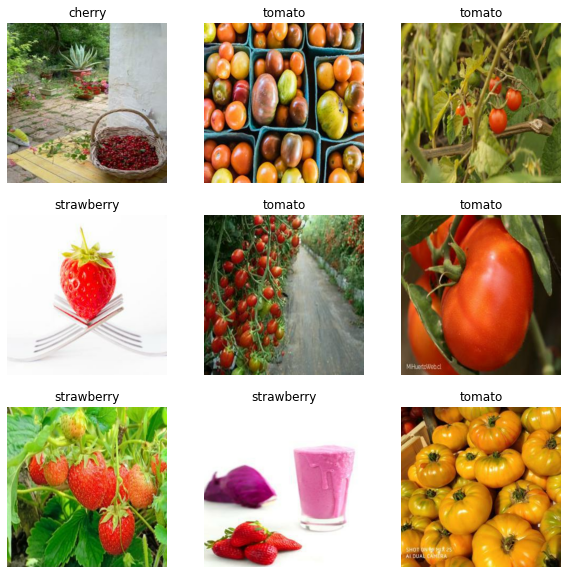

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



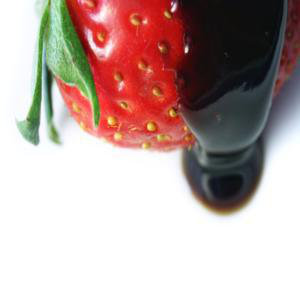

In [ ]:
strawberry = list(path.glob('strawberry/*'))
PIL.Image.open(str(strawberry[0]))

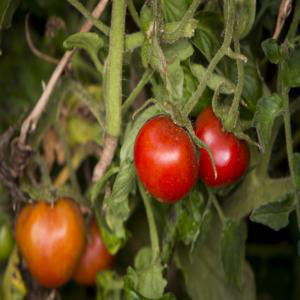

In [ ]:
tomato= list(path.glob('tomato/*'))
PIL.Image.open(str(tomato[0]))

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_vs = val_ds.map(lambda x, y: (normalization_layer(x), y))



In [ ]:
input_shape=(300,300,3)
weight_decay = 0.0001
batch_size = 16
num_epochs = 8
dropout_rate = 0.2
image_size = 300  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.
num_classes = 3

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
       normalized_ds,
  validation_data=normalized_vs,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
   

    # Return history to plot learning curves.
    return history

In [ ]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
       
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [ ]:
#mlpmixer_blocks = keras.Sequential(
 #   [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
#)
#learning_rate = 0.005
#mlpmixer_classifier = build_classifier(mlpmixer_blocks)
#history = run_experiment(mlpmixer_classifier)

In [ ]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras import layers,models
IMG_SIZE = 300

resize_and_rescale = models.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
])
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:

model = models.Sequential([ data_augmentation,
 layers.Conv2D(30,(3,3),activation='relu',input_shape=(300,300,3)),
  layers.MaxPooling2D((2,2)),
 layers.Conv2D(60,(3,3),activation='relu',input_shape=(300,300,3)),
  layers.MaxPooling2D((2,2)),
 layers.Conv2D(60,(3,3),activation='relu',input_shape=(300,300,3)),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(600,activation='relu'),
  layers.Dense(3)])





In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
model.compile(optimizer = 'adam' , loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
normalized_ds


<MapDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
history=model.fit(
  normalized_ds,
  validation_data=normalized_vs,
  epochs=15
)



Epoch 1/15
750/750 [==============================] - 59s 78ms/step - loss: 1.1264 - accuracy: 0.3471 - val_loss: 1.0991 - val_accuracy: 0.3235
Epoch 2/15
750/750 [==============================] - 58s 77ms/step - loss: 1.0994 - accuracy: 0.3276 - val_loss: 1.0987 - val_accuracy: 0.3242
Epoch 3/15
750/750 [==============================] - 58s 78ms/step - loss: 1.0990 - accuracy: 0.3201 - val_loss: 1.0987 - val_accuracy: 0.3242
Epoch 4/15
750/750 [==============================] - 58s 78ms/step - loss: 1.0990 - accuracy: 0.3154 - val_loss: 1.0987 - val_accuracy: 0.3242
Epoch 5/15
579/750 [======================>.......] - ETA: 12s - loss: 1.0989 - accuracy: 0.3230

KeyboardInterrupt: ignored

In [ ]:
!mkdir -p saved_model
model.save('/content/final_model.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
files.download('/content/final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>